# Rapidly-Exploring Random Tree (RRT)

Your task is to generate an RRT based on the following pseudocode:

```
def generate_RRT(x_init, num_vertices, dt):
    rrt = RRT(x_init)
    for k in range(num_vertices):
        x_rand = sample_state()
        x_near = nearest_neighbor(x_rand, rrt)
        u = select_input(x_rand, x_near)
        x_new = new_state(x_near, u, dt)
        # directed edge
        rrt.add_edge(x_near, x_new, u)
    return rrt
```
    
The `RRT` class has already been implemented. Your task is to complete the implementation of the following functions:

* `sample_state`
* `nearest_neighbor`
* `select_input`
* `new_state`


In [1]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt

from bresenham import bresenham
from sklearn.neighbors import KDTree

%matplotlib inline 

/Users/agrawac/miniconda3/envs/fcnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/agrawac/miniconda3/envs/fcnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/agrawac/miniconda3/envs/fcnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/agrawac/miniconda3/envs/fcnd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
def create_grid():
    grid = np.zeros((100, 100))
    # build some obstacles
    grid[10:20, 10:20] = 1
    grid[63:80, 10:20] = 1
    grid[43:60, 30:40] = 1
    grid[71:86, 38:50] = 1
    grid[10:20, 55:67] = 1
    grid[80:90, 80:90] = 1
    grid[75:90, 80:90] = 1
    grid[30:40, 60:82] = 1
    return grid

In [4]:
# environment encoded as a grid
grid = create_grid()

Let's take a look at the example environment we'll be using.

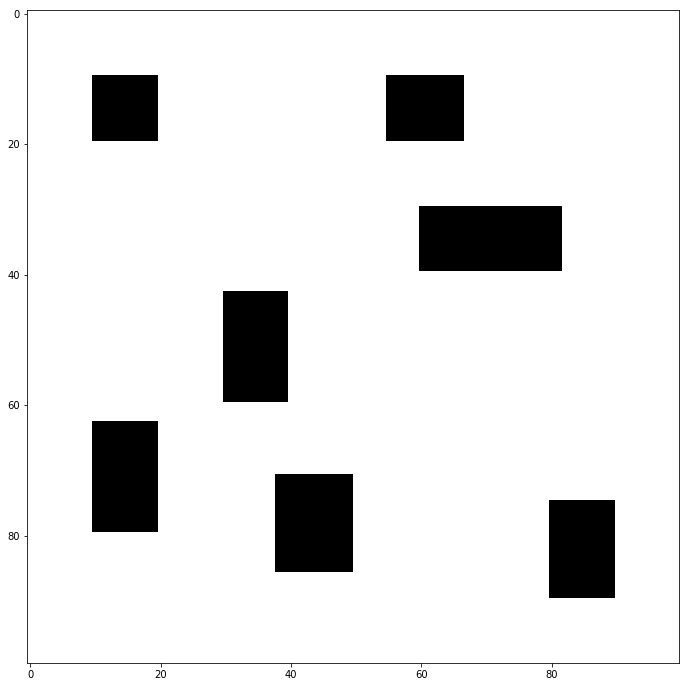

In [5]:
plt.imshow(grid, cmap='Greys', origin='upper')

Next you'll implement the functions necessary to generate an RRT. Feel free to change the function signatures however you please, just remember to update `generate_RRT` accordingly.

### Sampling States

The first part of generating an RRT is sampling states based on the environment. The sampled state must be in free space. 

In [6]:
class RRT:
    def __init__(self, x_init):
        # A tree is a special case of a graph with
        # directed edges and only one path to any vertex.
        self.tree = nx.DiGraph()
        self.tree.add_node(x_init)
        self.start = x_init
                
    def add_vertex(self, x_new):
        self.tree.add_node(tuple(x_new))
    
    def add_edge(self, x_near, x_new, u):
        self.tree.add_edge(tuple(x_near), tuple(x_new), orientation=u)
    
    def remove_edge(self, x_near, x_new):
        self.tree.remove_edge(tuple(x_near), tuple(x_new))
    
    def parent(self, x):
        return list(self.tree.predecessors(tuple(x)))[0]
        
    def cost(self, source_node, node):
        return np.linalg.norm(np.array(source_node) - np.array(node))
    
    def path_cost(self, path):
        total_cost = 0
        for i in range(1, len(path)):
            total_cost += self.cost(path[i-1], path[i])
        return total_cost
    
    def shortest_path(self, node):
        return nx.shortest_path(self.tree, source=self.start, target=tuple(node))
    
    @property
    def vertices(self):
        return self.tree.nodes()
    
    @property
    def edges(self):
        return self.tree.edges()


In [7]:
def sample_state(grid):
    x = np.random.uniform(0, grid.shape[0])
    y = np.random.uniform(0, grid.shape[1])
    return (x, y)

def sample_free_state(grid):
    x_rand = sample_state(grid)
    # sample states until a free state is found
    while grid[int(x_rand[0]), int(x_rand[1])] == 1:
        x_rand = sample_state(grid)
    return x_rand

def select_input(x_rand, x_near):
    return np.arctan2(x_rand[1] - x_near[1], x_rand[0] - x_near[0])

def new_state(x_near, u, dt):
    nx = x_near[0] + np.cos(u) * dt
    ny = x_near[1] + np.sin(u) * dt
    return [nx, ny]

def nearest_neighbor(x_rand, rrt):
    closest_dist = 100000
    closest_vertex = None
    x_rand = np.array(x_rand)
    
    for v in rrt.vertices:
        d = np.linalg.norm(x_rand - np.array(v[:2]))
        if d < closest_dist:
            closest_dist = d
            closest_vertex = v
    return closest_vertex

def near_neighbors(x, rrt, alpha=2):
    neighbors = []
    x_ver = np.array(x)
    
    for v in rrt.vertices:
        d = np.linalg.norm(x_ver - np.array(v[:2]))
        if d < alpha:
            neighbors.append(v)
    return neighbors

def obstacle_free(grid, existing_node, new_node):
    line = [int(existing_node[0]), int(existing_node[1]), int(new_node[0]), int(new_node[1])]
    cells = list(bresenham(line[0], line[1], line[2], line[3]))
    for cell in cells:
        if grid[int(cell[0]), int(cell[1])] == 1:
            return False
    return True

def choose_best_parent(grid, x_nearest, x_new, X_near, rrt):
    x_min = x_nearest
    best_cost = 1000000#rrt.short_length(x_min) + rrt.short_length(x_min, x_new)
    for x_near in X_near:
        if obstacle_free(grid, x_near, x_new):
            cost = rrt.path_cost(rrt.shortest_path(x_near)) + rrt.cost(x_near, x_new)
            if cost < best_cost:
                best_cost = cost
                x_min = x_near
    return x_min

def rewire_vertices(grid, x_new, X_near, rrt):
    for v in X_near:
        if obstacle_free(grid, v, x_new) and \
        rrt.path_cost(rrt.shortest_path(v)) > (rrt.path_cost(rrt.shortest_path(x_new)) + rrt.cost(v, x_new)):
            x_parent = rrt.parent(v)
            rrt.remove_edge(x_parent, v)
            u_parent = select_input(v, x_new)
            rrt.add_edge(x_new, v, u_parent)

def connect(grid, x_new, x_conn, bi_rrt, dt):
    u = select_input(x_conn, x_new)
    z_new = new_state(x_new, u, dt)
    if obstacle_free(grid, x_conn, z_new) and obstacle_free(grid, z_new, x_new):
        Z_near = near_neighbors(z_new, bi_rrt[1])
        z_min = choose_best_parent(grid, x_conn, z_new, Z_near, bi_rrt[1])
        bi_rrt[1].add_edge(z_min, z_new, u)
        return bi_rrt[0].shortest_path(x_new) + bi_rrt[1].shortest_path(z_min)
    return None

def bi_potential(x_goal, x_prand, potential_gain):
    return -1. * potential_gain * np.abs(x_prand - x_goal)

def nearest_obstacle(grid, x):
    ruturn x

def bi_potential_gradient(grid, x_rand, x_goal):
    x_prand = x_rand
    return x_prand

In [8]:
def generate_BiRRT(grid, x_init, x_goal, num_vertices, dt):
    
    path_best = None
    bi_rrt = [RRT(x_init), RRT(x_goal)]
    
    for _ in range(num_vertices):
        x_rand = sample_free_state(grid)
        x_nearest = nearest_neighbor(x_rand, bi_rrt[0])
        u = select_input(x_rand, x_nearest)
        x_new = new_state(x_nearest, u, dt)
        
        if obstacle_free(grid, x_nearest, x_new):
            X_near = near_neighbors(x_new, bi_rrt[0])
            # Assign minimal cost neighbor
            x_min = choose_best_parent(grid, x_nearest, x_new, X_near, bi_rrt[0])
            bi_rrt[0].add_edge(x_min, x_new, u)
            
            # Try x_new as parent for near neigbors
            rewire_vertices(grid, x_new, X_near, bi_rrt[0])
        
            x_conn = nearest_neighbor(x_new, bi_rrt[1])
            path_new = connect(grid, x_new, x_conn, bi_rrt, dt)
            if path_new is not None:
                if path_best is None:
                    path_best = path_new
                elif bi_rrt[1].path_cost(path_new) < bi_rrt[1].path_cost(path_best):
                    path_best = path_new
        
        # Swap trees
        bi_rrt[0], bi_rrt[1] = bi_rrt[1], bi_rrt[0]
    
    return bi_rrt, path_best

In [9]:
def generate_PB_RRT(grid, x_init, x_goal, num_vertices, dt):
    
    path_best = None
    bi_rrt = [RRT(x_init), RRT(x_goal)]
    
    for _ in range(num_vertices):
        x_rand = sample_free_state(grid)
        x_prand = bi_potential_gradient(grid, x_rand, bi_rrt[1].start)
        x_nearest = nearest_neighbor(x_prand, bi_rrt[0])
        u = select_input(x_prand, x_nearest)
        x_new = new_state(x_nearest, u, dt)
        
        if obstacle_free(grid, x_nearest, x_new):
            X_near = near_neighbors(x_new, bi_rrt[0])
            # Assign minimal cost neighbor
            x_min = choose_best_parent(grid, x_nearest, x_new, X_near, bi_rrt[0])
            bi_rrt[0].add_edge(x_min, x_new, u)
            
            # Try x_new as parent for near neigbors
            rewire_vertices(grid, x_new, X_near, bi_rrt[0])
        
            x_conn = nearest_neighbor(x_new, bi_rrt[1])
            path_new = connect(grid, x_new, x_conn, bi_rrt, dt)
            if path_new is not None:
                if path_best is None:
                    path_best = path_new
                elif bi_rrt[1].path_cost(path_new) < bi_rrt[1].path_cost(path_best):
                    path_best = path_new
        
        # Swap trees
        bi_rrt[0], bi_rrt[1] = bi_rrt[1], bi_rrt[0]
    
    return bi_rrt, path_best

Feel free to change any of the values below.

In [10]:
num_vertices = 200
dt = 1
start = (50, 50)
goal = (60, 10)

#rrt = generate_RRT(grid, start, num_vertices, dt)
#rrt_star = generate_RRT_star(grid, start, num_vertices, dt)
bi_rrt, _ = generate_BiRRT(grid, start, goal, num_vertices, dt)
pb_rrt, optimal_path = generate_PB_RRT(grid, start, goal, num_vertices, dt)

Now let's plot the generated RRT.

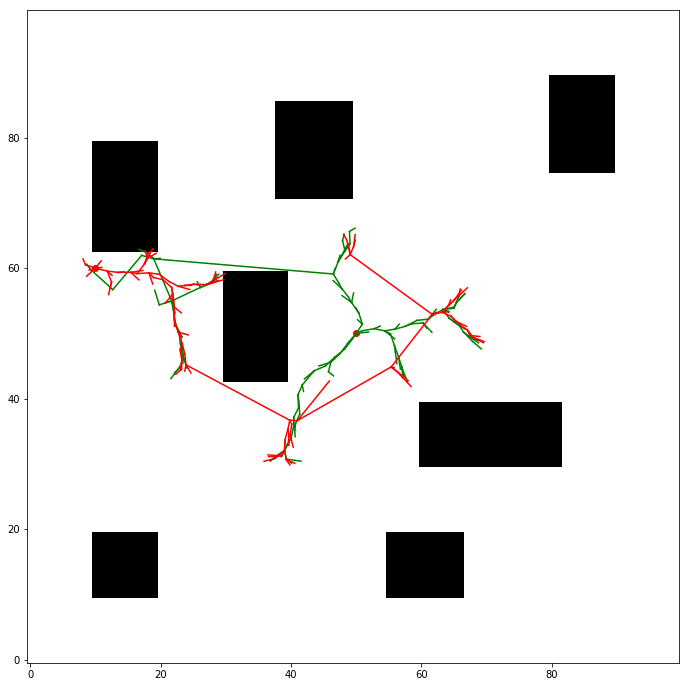

In [11]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start[1], start[0], 'ro')
plt.plot(goal[1], goal[0], 'ro')

for (v1, v2) in bi_rrt[0].edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'g-')
for (v1, v2) in bi_rrt[1].edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'r-')

plt.show()

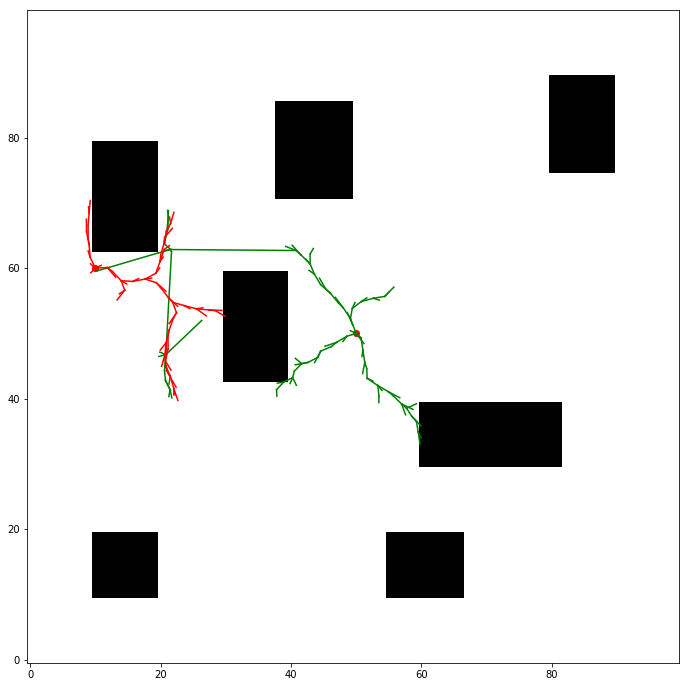

In [12]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start[1], start[0], 'ro')
plt.plot(goal[1], goal[0], 'ro')

for (v1, v2) in pb_rrt[0].edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'g-')
for (v1, v2) in pb_rrt[1].edges:
    plt.plot([v1[1], v2[1]], [v1[0], v2[0]], 'r-')

plt.show()

[(50, 50), (51.35240574530664, 49.44621780586746), (52.29595352331997, 49.11498134862566), (53.934902046474924, 47.98722272946146), (54.64642311678876, 47.284557968355955), (56.16341885525557, 46.031123097632765), (57.482954943893105, 44.52896184296768), (59.088350575785356, 43.58006228242244), (60.64178922231392, 42.934051294096975), (62.04052430171362, 41.51056483273834), (62.70433005823055, 40.762659813624964), (62.85344946923005, 21.563797730280292), (62.33108616475076, 19.650739266739244), (60, 10), (60.094522403117956, 11.844521463865517), (59.47959169671068, 12.633102611444793), (58.07272842396228, 13.96489699858636), (57.965525394188894, 15.744523112666938), (58.328408894764515, 17.6365372716715), (59.21943186266687, 19.27995303243697), (61.027209102053014, 19.925762508832822)]


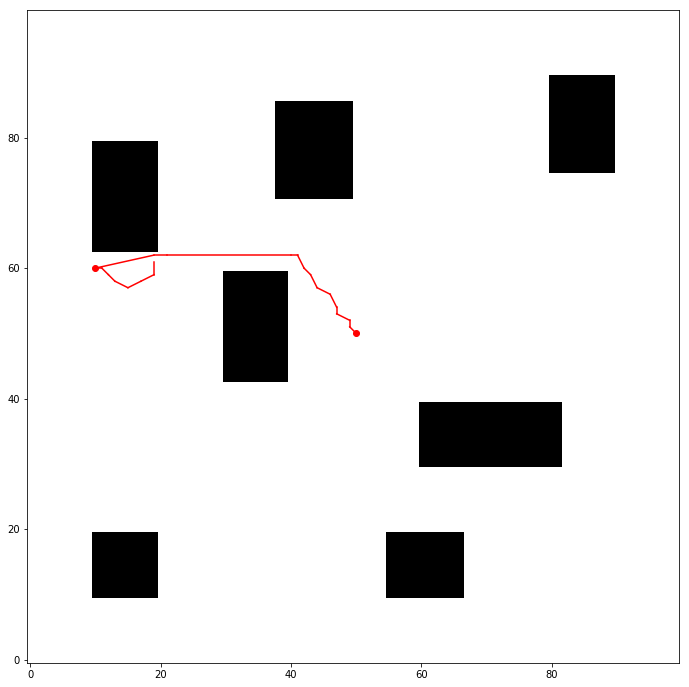

In [13]:
print(optimal_path)

plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(start[1], start[0], 'ro')
plt.plot(goal[1], goal[0], 'ro')


last_v = None
for (x, y) in optimal_path:
    if last_v is None:
        last_v = [x, y]
        continue
    plt.plot([int(last_v[1]), int(y)], [int(last_v[0]), int(x)], 'r-')
    last_v = [x, y]

plt.show()

[solution](/notebooks/RRT-Solution.ipynb)